In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

import os
import sys
path = os.getcwd()+'/drive/MyDrive/NSSP_Project2/'
sys.path.append(os.getcwd()+'/drive/MyDrive/NSSP_Project2/')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Generalization Across Subjects

In [7]:
mean_std_norm = lambda x: (x - x.mean()) / x.std()

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None, feature_norm=False):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions

    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)

    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                cur_feature = feature(emg[selected_tsteps, :])
                if feature_norm:
                    cur_feature = mean_std_norm(cur_feature)
                dataset[current_sample_index, selected_features] = cur_feature
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1

    # Return the constructed dataset and corresponding labels
    return dataset, labels

dataset dimension: (120, 60)
labels dimension: (120,)


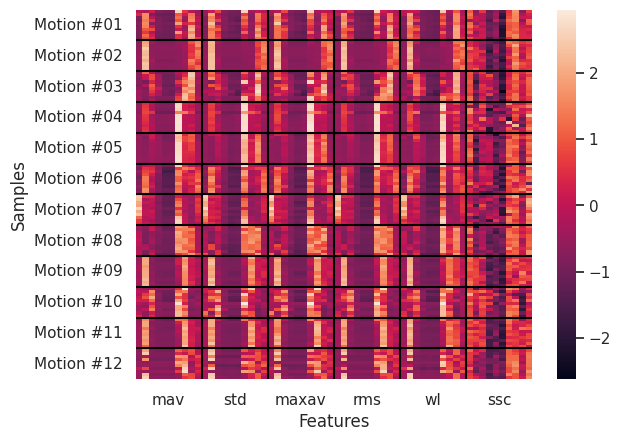

In [9]:
# Define the features

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Zero Crossing (ZC)
zc = lambda x: np.sum((x[:-1, :] * x[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg_filtered,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc],
    feature_norm=True
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")
sns.heatmap(dataset)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.yticks(range(5, 116, 10), [f'Motion #%02d' % (x+1) for x in range(12)])
plt.xticks(range(5, 56, 10), ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc'])

ax = plt.gca()
for x in range(10, dataset.shape[1], 10):  # 每隔10个特征
    ax.axvline(x=x, color='black', linestyle='-', linewidth=1.5)
for y in range(10, dataset.shape[0], 10):  # 每隔10个样本
    ax.axhline(y=y, color='black', linestyle='-', linewidth=1.5)


### 2.1. Load EMG data of all 27 subjects, and perform the same preprocessing pipeline

In [10]:
dataset_all = np.zeros((0, 60))
labels_all = np.zeros((0,))
for sub_idx in range(1, 27+1):

    # 1. Load data

    print('---- Loading Data From {sub_idx}')
    EMG_file_name = f's{sub_idx}/S{sub_idx}_A1_E1.mat'
    emg_data = loadmat(path+EMG_file_name)
    emg = emg_data["emg"].copy()
    stimulus = emg_data["restimulus"]
    repetition = emg_data["rerepetition"]
    print(f'    EMG: {emg.shape}, Stimulus {stimulus.shape}, Repetition {repetition.shape}')

    # 2. Perform bandpass filtering

    n_channels = emg.shape[1]
    fs = 2000
    time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)
    bandpass_cutoff_frequencies_Hz = (15, 500)
    sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg.T).T
    powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics
    for noise_frequency in powergrid_noise_frequencies_Hz:
        sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos, emg_filtered.T).T
    n_stimuli = len(np.unique(stimulus)) - 1
    n_repetitions = len(np.unique(repetition)) - 1
    n_channels = emg_filtered.shape[1]
    print(f'    n_stimuli: {n_stimuli}, n_repetitions: {n_repetitions}, n_channels: {n_channels}\n')

    # 3. Moving average
    mov_mean_size = 200
    mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

    dataset, labels = build_dataset_from_ninapro(
        emg=emg_filtered,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc],
        feature_norm=True
    )
    dataset_all = np.vstack((dataset_all, dataset))
    labels_all = np.hstack((labels_all, labels))

---- Loading Data From {sub_idx}
    EMG: (101014, 10), Stimulus (101014, 1), Repetition (101014, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100686, 10), Stimulus (100686, 1), Repetition (100686, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100720, 10), Stimulus (100720, 1), Repetition (100720, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100835, 10), Stimulus (100835, 1), Repetition (100835, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100894, 10), Stimulus (100894, 1), Repetition (100894, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (101083, 10), Stimulus (101083, 1), Repetition (101083, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100817, 10), Stimulus (1008

### 2.2. Extract the same set of features, look at the values across different subjects.

dataset dimension: (3240, 60)
labels dimension: (3240,)


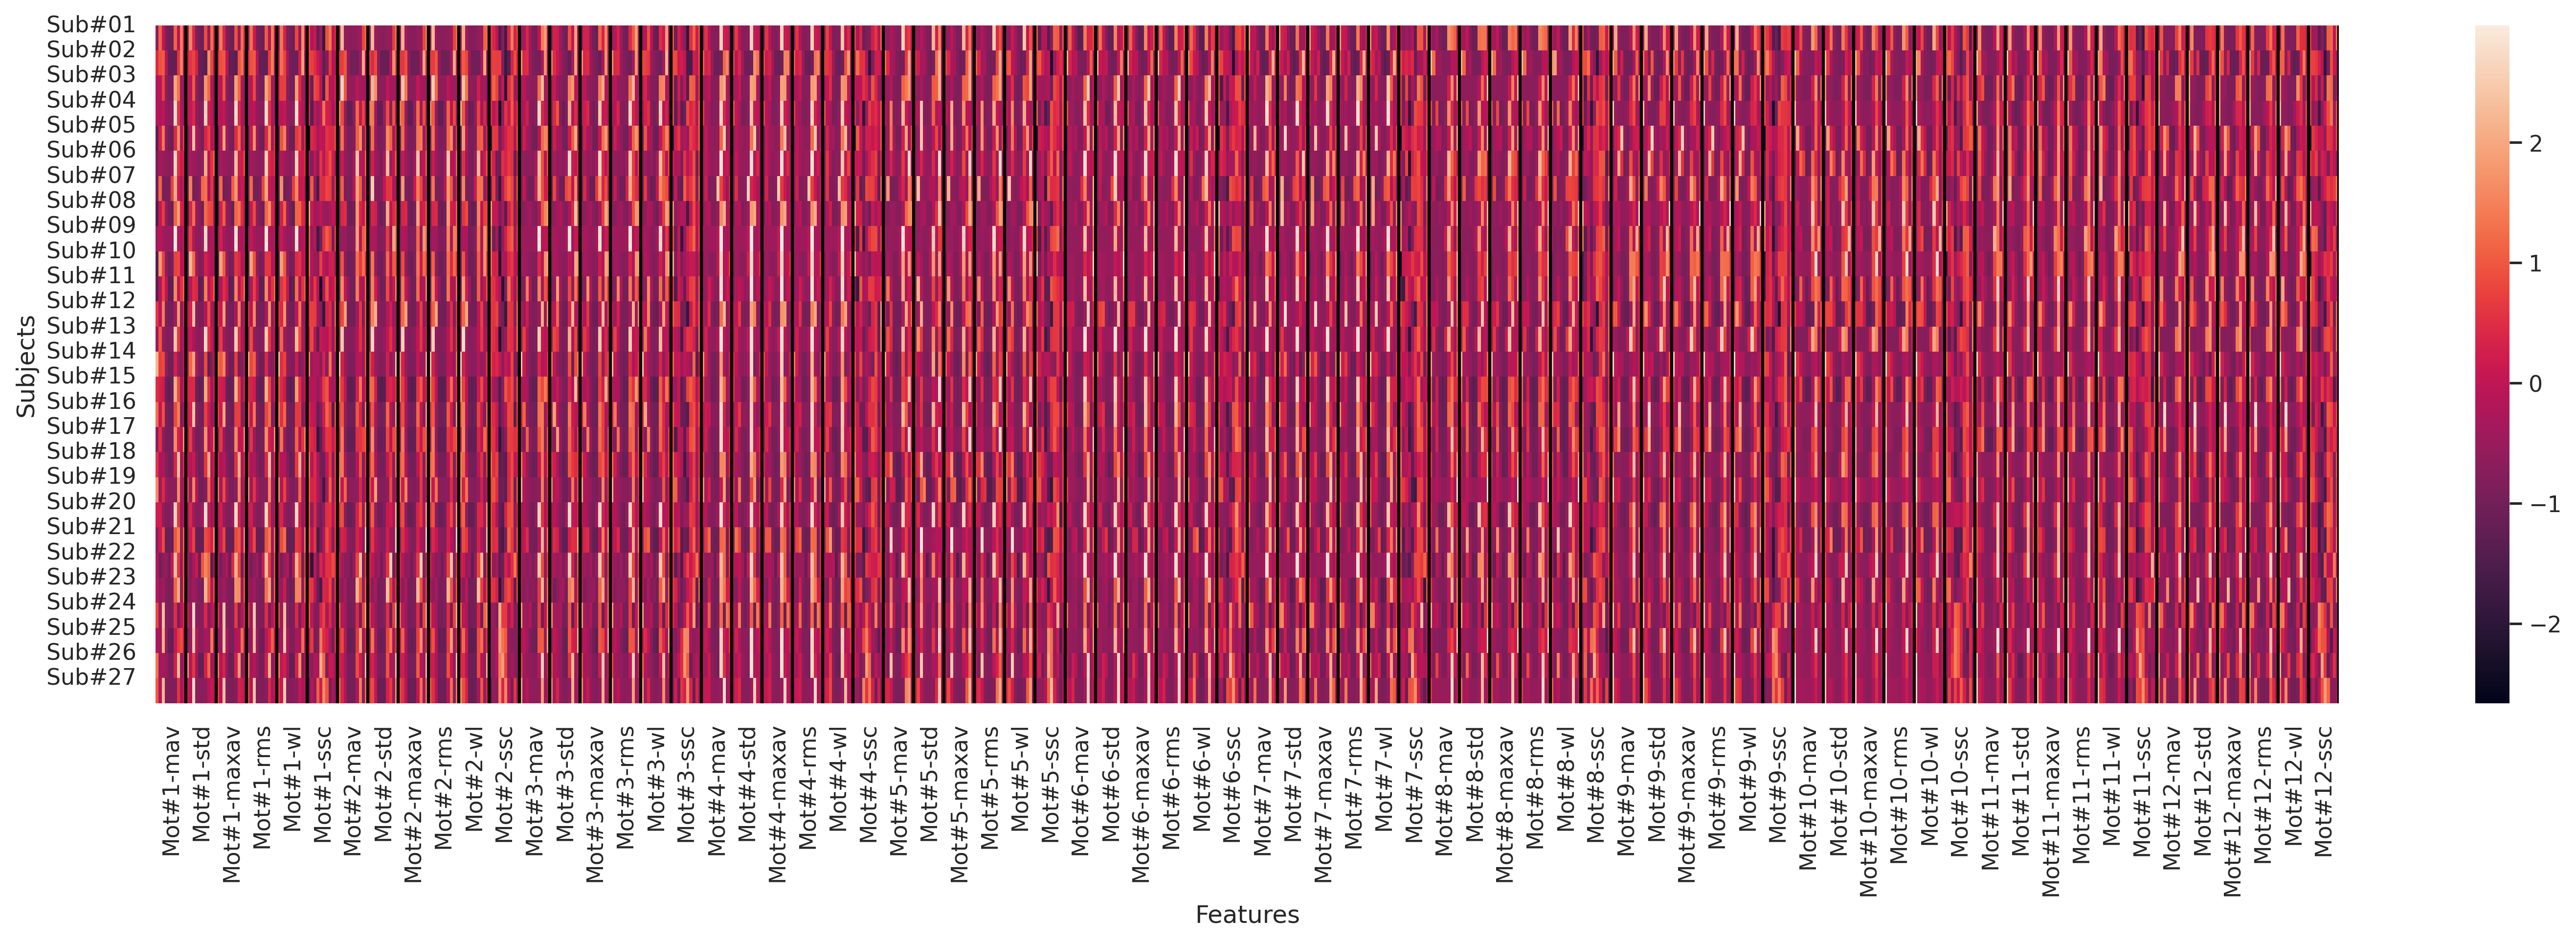

In [16]:
print(f"dataset dimension: {dataset_all.shape}")
print(f"labels dimension: {labels_all.shape}")
# Average across repetitions
dataset_all_rep_avg = np.array([dataset_all[rep_idx*10:(rep_idx+1)*10, :].mean(axis=0) for rep_idx in range(12*27)])
# Reshape so that each row is all 720 features (motion=12 x feature=6 x channels=10) of 1 subject
dataset_all_rep_avg = np.array([dataset_all_rep_avg[sub_idx*12:(sub_idx+1)*12].reshape(-1) for sub_idx in range(27)])

plt.figure(figsize=(24, 6), dpi=300)
sns.heatmap(dataset_all_rep_avg)
plt.xlabel('Features')
plt.ylabel('Subjects')
plt.yticks(range(27), [f'Sub#%02d' % (x+1) for x in range(27)], rotation=0)
feature_list = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc']
plt.xticks(range(5, 716, 10), [f'Mot#{mot_idx+1}-{feature}' for mot_idx in range(12) for feature in feature_list])
ax = plt.gca()
for x in range(10, dataset_all.shape[0], 10):  # 每隔10个特征
    ax.axvline(x=x, color='black', linestyle='-', linewidth=1.5)

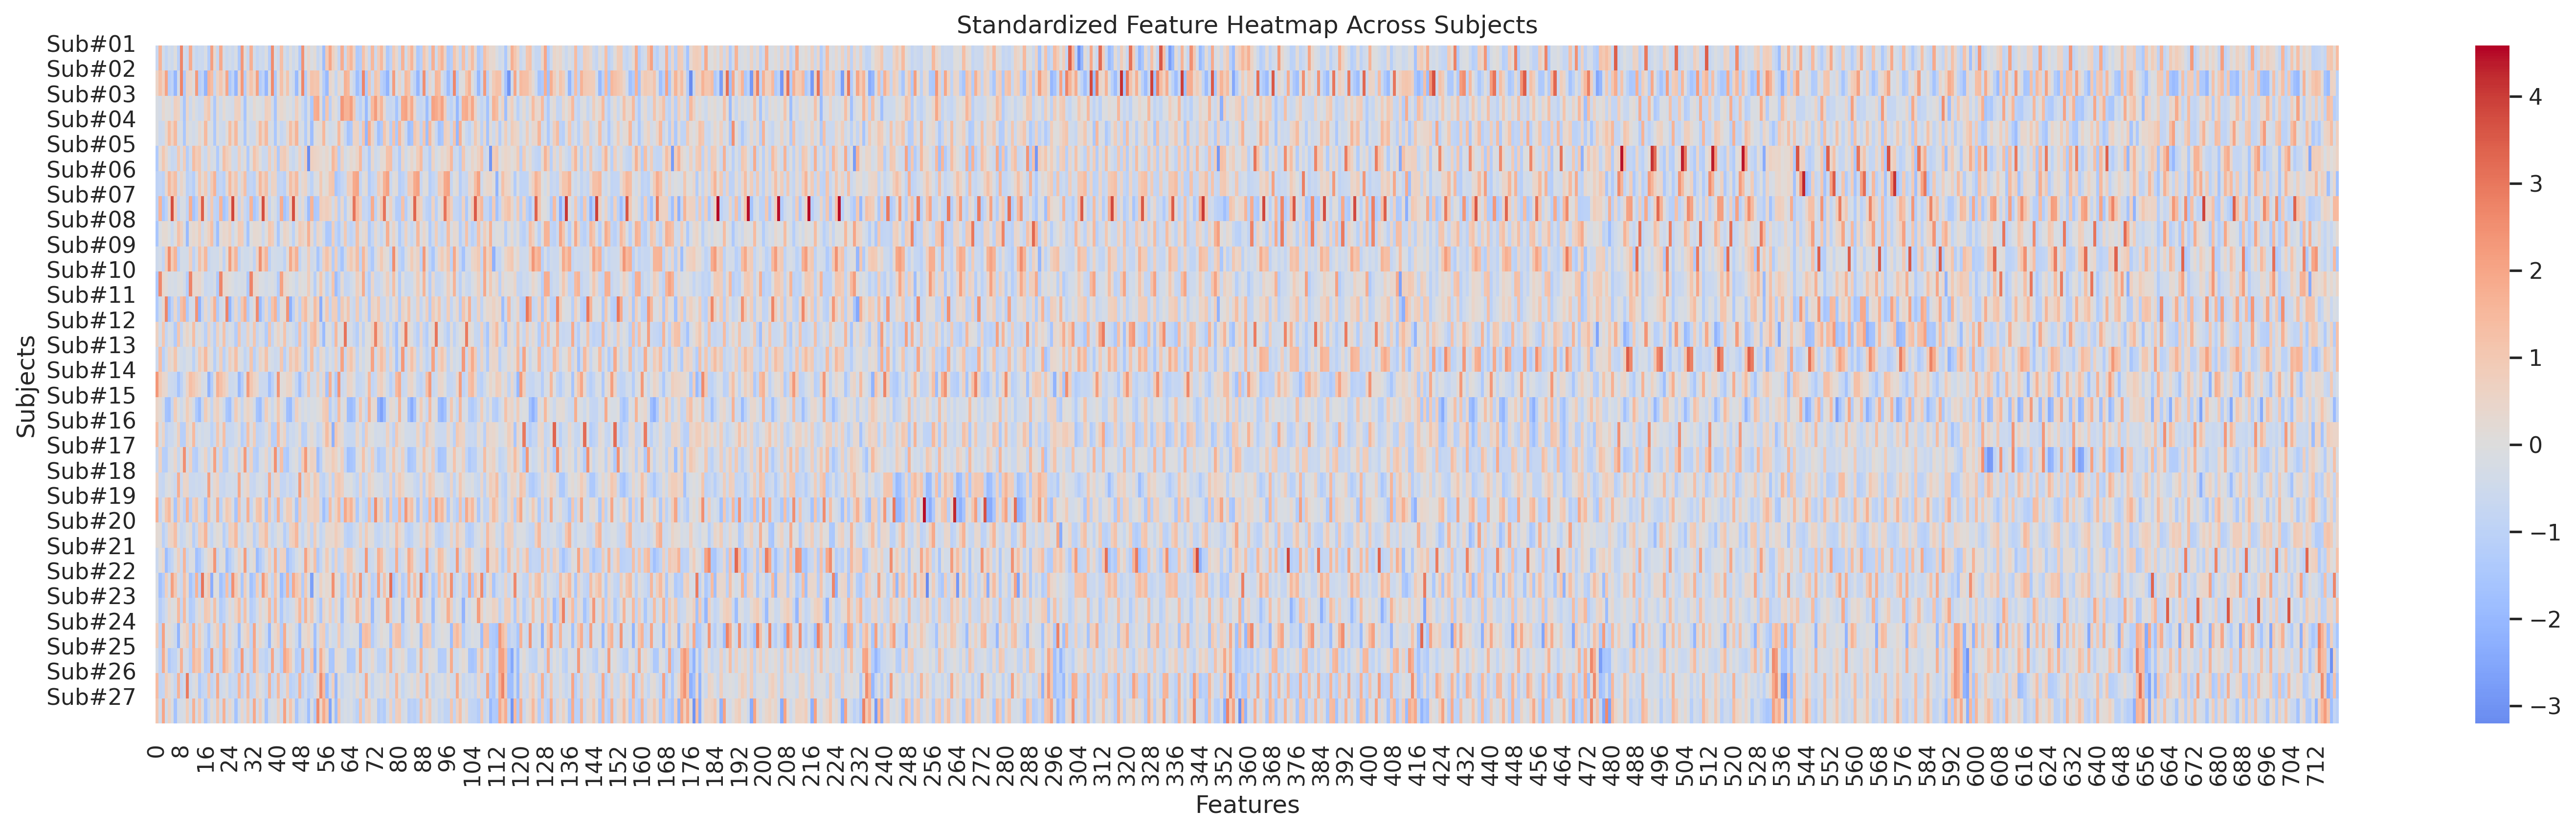

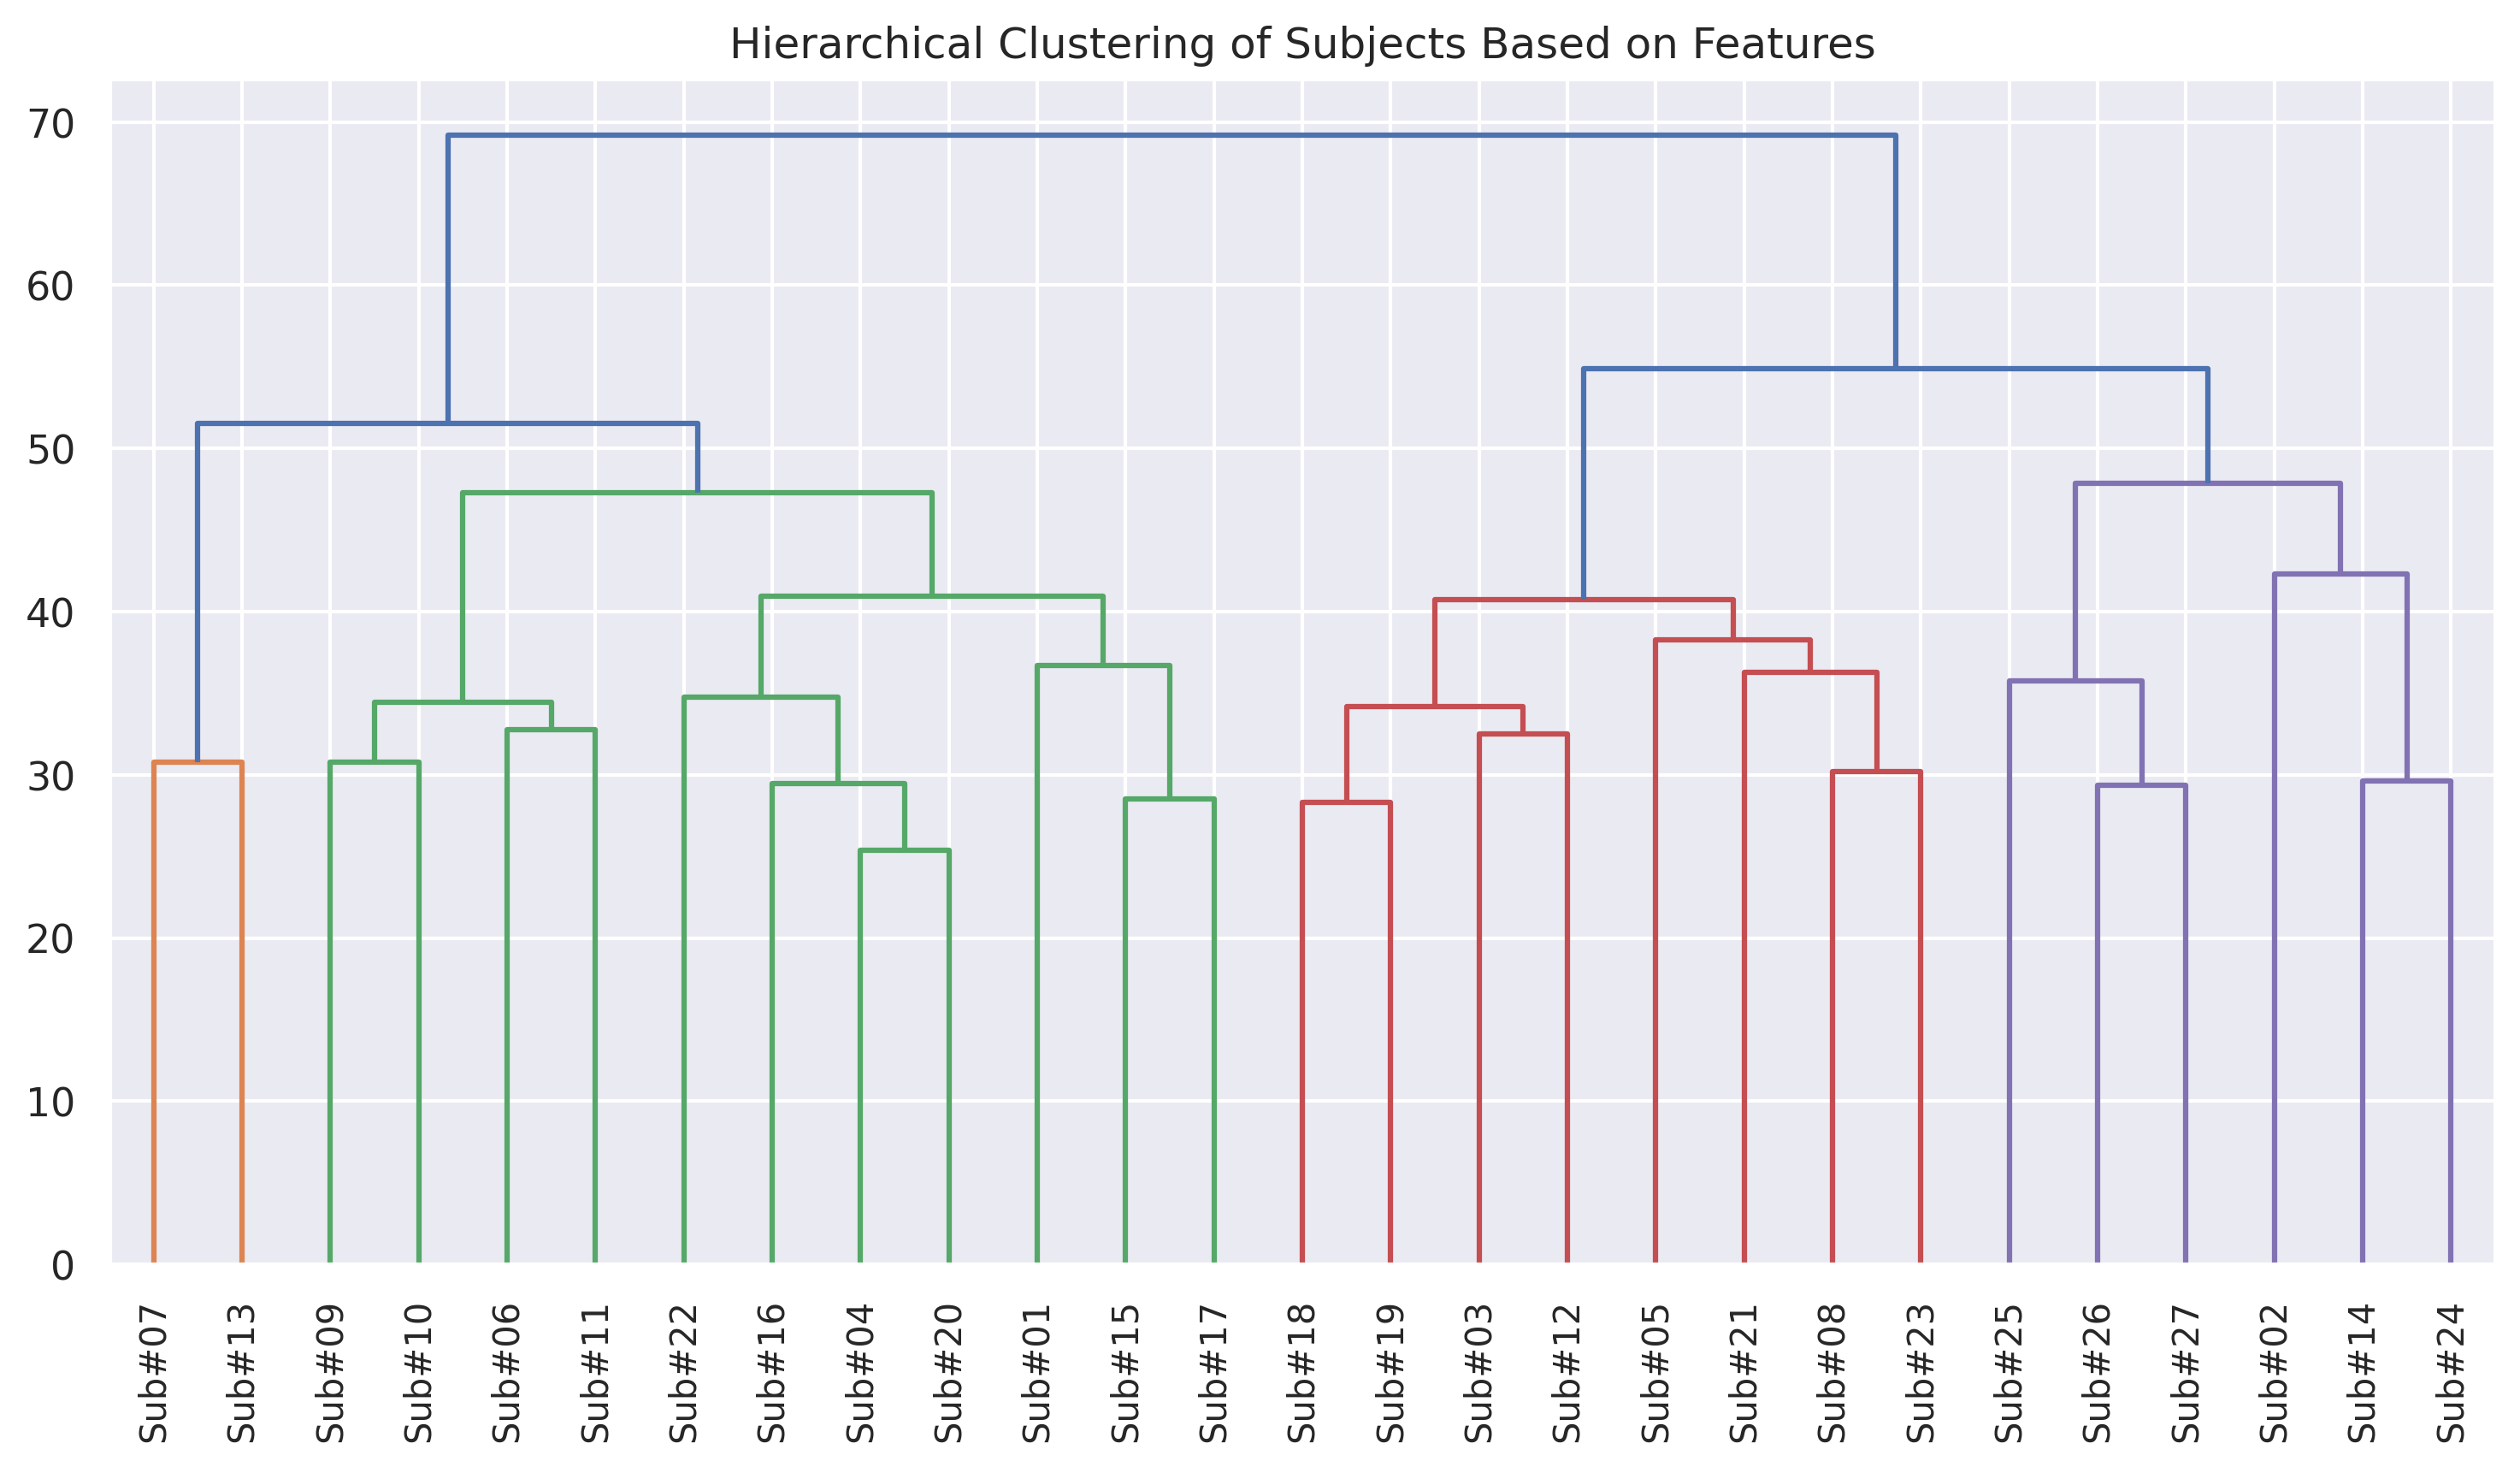

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Standardize the features
scaler = StandardScaler()
dataset_all_std = scaler.fit_transform(dataset_all_rep_avg)

# Enhanced heatmap with standardized features
plt.figure(figsize=(24, 6), dpi=300)
sns.heatmap(dataset_all_std, cmap='coolwarm', center=0)
plt.xlabel('Features')
plt.ylabel('Subjects')
plt.title("Standardized Feature Heatmap Across Subjects")
plt.yticks(range(27), [f'Sub#%02d' % (x+1) for x in range(27)], rotation=0)
plt.show()

# Clustering of Subjects
linked = linkage(dataset_all_std, method='ward')
plt.figure(figsize=(12, 6), dpi=300)
dendrogram(linked, labels=[f'Sub#%02d' % (x+1) for x in range(27)], leaf_rotation=90)
plt.title('Hierarchical Clustering of Subjects Based on Features')
plt.show()


### 2.3. Train a classification model on 26 subjects, and test it on a subject outside the train set.

n_training: 84, n_validation: 18, n_test: 18
Accuracy score: 0.8333333333333334


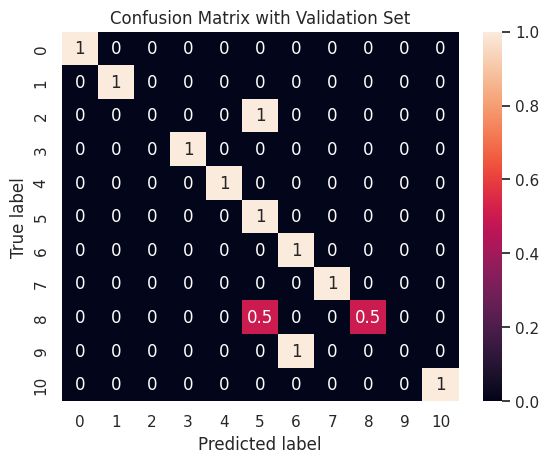

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'n_training: {X_train.shape[0]}, n_validation: {X_val.shape[0]}, n_test: {X_test.shape[0]}')

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)

# Classifier
clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
X_train_z = np.nan_to_num(X_train_z)
clf.fit(X_train_z, y_train)

# Predict in validation
y_pred = clf.predict(X_val_z)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Validation Set")
plt.show()

(3240, 60)
Training data shape: (3120, 60), Testing data shape: (120, 60)
Accuracy score on subject 27: 0.225


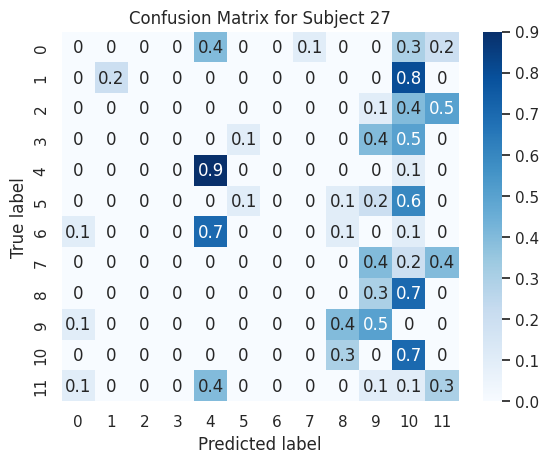

In [17]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


# 数据分割：前26个被试训练，27号被试测试
n_subjects = 27
samples_per_subject = 120  # 每个被试有120个样本

# 手动分离数据
train_subjects = 26  # 用于训练的被试数目
print(dataset_all.shape)
X_train = dataset_all[:train_subjects * samples_per_subject, :]  # 前26个被试数据
y_train = labels_all[:train_subjects * samples_per_subject]

X_test = dataset_all[train_subjects * samples_per_subject:, :]   # 第27个被试数据
y_test = labels_all[train_subjects * samples_per_subject:]

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

# 数据标准化（StandardScaler）
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # 在训练数据上fit
X_test_z = scaler.transform(X_test)        # 用训练的scaler标准化测试数据

clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
X_train_z = np.nan_to_num(X_train_z)
clf.fit(X_train_z, y_train)

X_test_z = np.nan_to_num(X_test_z)
y_pred = clf.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score on subject 27: {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix for Subject 27")
plt.show()


## Code for Leave-One-Subject-Out Cross-Validation (LOSO-CV)

In [26]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Number of subjects and samples per subject
n_subjects = 27
samples_per_subject = 120  # Each subject has 120 samples

# Assuming dataset and labels are provided
# dataset: shape (n_subjects * samples_per_subject, n_features)
# labels: shape (n_subjects * samples_per_subject,)

# Placeholder for results
accuracy_list = []

# Create a folder to save the confusion matrix images
output_folder = "confusion_matrices"
os.makedirs(output_folder, exist_ok=True)

# Leave-One-Subject-Out Cross-Validation
for test_subject in range(n_subjects):
    print(f"\nFold {test_subject + 1}: Testing on Subject {test_subject + 1}")

    # Define train and test indices
    test_start = test_subject * samples_per_subject
    test_end = test_start + samples_per_subject

    X_test = dataset_all[test_start:test_end, :]
    y_test = labels_all[test_start:test_end]

    X_train = np.delete(dataset_all, np.s_[test_start:test_end], axis=0)  # Remove test subject
    y_train = np.delete(labels_all, np.s_[test_start:test_end], axis=0)   # Remove test subject labels

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Train the model
    clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    clf.fit(X_train_z, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    print(f"Accuracy for Subject {test_subject + 1}: {accuracy:.4f}")

    # Confusion matrix for the current fold (optional visualization)
    confmat = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(6, 5))
    sns.heatmap(confmat, annot=True, cmap="Blues")
    plt.title(f"Confusion Matrix for Subject {test_subject + 1}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # Save confusion matrix image
    save_path = os.path.join(output_folder, f"confusion_matrix_subject_{test_subject + 1}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.close()
    print(f"Confusion matrix saved to: {save_path}")

# Final evaluation
average_accuracy = np.mean(accuracy_list)
print("\nFinal Evaluation Across All Folds:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Accuracies for Each Fold: {accuracy_list}")



Fold 1: Testing on Subject 1
Accuracy for Subject 1: 0.3750
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_1.png

Fold 2: Testing on Subject 2
Accuracy for Subject 2: 0.0000
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_2.png

Fold 3: Testing on Subject 3
Accuracy for Subject 3: 0.3000
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_3.png

Fold 4: Testing on Subject 4
Accuracy for Subject 4: 0.1583
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_4.png

Fold 5: Testing on Subject 5
Accuracy for Subject 5: 0.2833
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_5.png

Fold 6: Testing on Subject 6
Accuracy for Subject 6: 0.3083
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_6.png

Fold 7: Testing on Subject 7
Accuracy for Subject 7: 0.2333
Confusion matrix saved to: confusion_matrices/confusion_matrix_subject_7.png

Fold 8: Testing on Subject 8
Accu


Training with 1 subjects
Accuracy with 1 subjects: 0.0500

Training with 2 subjects
Accuracy with 2 subjects: 0.1083

Training with 3 subjects
Accuracy with 3 subjects: 0.1667

Training with 4 subjects
Accuracy with 4 subjects: 0.1667

Training with 5 subjects
Accuracy with 5 subjects: 0.1083

Training with 6 subjects
Accuracy with 6 subjects: 0.1167

Training with 7 subjects
Accuracy with 7 subjects: 0.1000

Training with 8 subjects
Accuracy with 8 subjects: 0.1333

Training with 9 subjects
Accuracy with 9 subjects: 0.1583

Training with 10 subjects
Accuracy with 10 subjects: 0.1583

Training with 11 subjects
Accuracy with 11 subjects: 0.2167

Training with 12 subjects
Accuracy with 12 subjects: 0.1917

Training with 13 subjects
Accuracy with 13 subjects: 0.1667

Training with 14 subjects
Accuracy with 14 subjects: 0.1750

Training with 15 subjects
Accuracy with 15 subjects: 0.1917

Training with 16 subjects
Accuracy with 16 subjects: 0.1750

Training with 17 subjects
Accuracy with 1

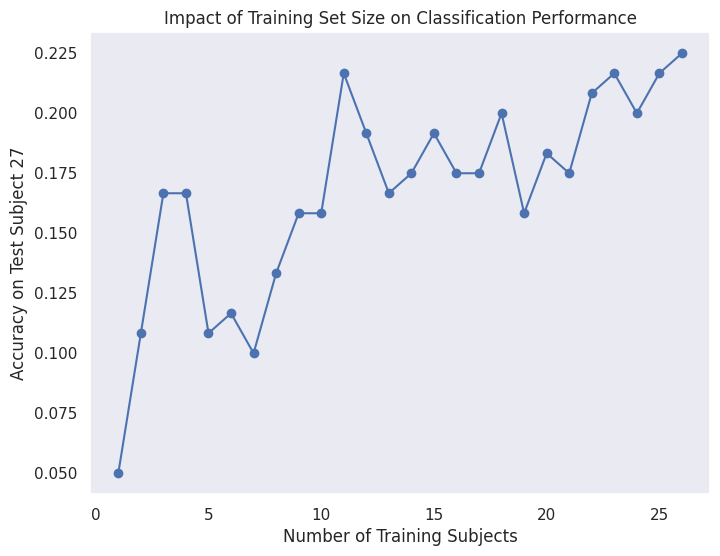

Accuracy trend plot saved to: accuracy_plots/accuracy_trend_subject27.png
Final Results:
Training with 1 subjects: Accuracy = 0.0500
Training with 2 subjects: Accuracy = 0.1083
Training with 3 subjects: Accuracy = 0.1667
Training with 4 subjects: Accuracy = 0.1667
Training with 5 subjects: Accuracy = 0.1083
Training with 6 subjects: Accuracy = 0.1167
Training with 7 subjects: Accuracy = 0.1000
Training with 8 subjects: Accuracy = 0.1333
Training with 9 subjects: Accuracy = 0.1583
Training with 10 subjects: Accuracy = 0.1583
Training with 11 subjects: Accuracy = 0.2167
Training with 12 subjects: Accuracy = 0.1917
Training with 13 subjects: Accuracy = 0.1667
Training with 14 subjects: Accuracy = 0.1750
Training with 15 subjects: Accuracy = 0.1917
Training with 16 subjects: Accuracy = 0.1750
Training with 17 subjects: Accuracy = 0.1750
Training with 18 subjects: Accuracy = 0.2000
Training with 19 subjects: Accuracy = 0.1583
Training with 20 subjects: Accuracy = 0.1833
Training with 21 sub

In [24]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

# Number of subjects and samples per subject
n_subjects = 27
samples_per_subject = 120  # Each subject has 120 samples

# Placeholder for accuracy results
accuracy_list = []
train_subject_counts = list(range(1, n_subjects))  # Train using 1, 2, ..., 26 subjects

# Test set: Subject 27
test_subject = n_subjects - 1  # Index of subject 27
test_start = test_subject * samples_per_subject
test_end = test_start + samples_per_subject
X_test = dataset_all[test_start:test_end, :]
y_test = labels_all[test_start:test_end]

# Output directory for saving images
output_folder = "accuracy_plots"
os.makedirs(output_folder, exist_ok=True)

# Loop to vary the number of training subjects
for num_train_subjects in train_subject_counts:
    print(f"\nTraining with {num_train_subjects} subjects")

    # Define training data (subjects 1 to num_train_subjects)
    train_end = num_train_subjects * samples_per_subject
    X_train = dataset_all[:train_end, :]
    y_train = labels_all[:train_end]

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Train the model
    clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    clf.fit(X_train_z, y_train)

    # Predict on test data (subject 27)
    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    print(f"Accuracy with {num_train_subjects} subjects: {accuracy:.4f}")

# Plot accuracy trend
plt.figure(figsize=(8, 6))
plt.plot(train_subject_counts, accuracy_list, marker='o', linestyle='-')
plt.xlabel("Number of Training Subjects")
plt.ylabel("Accuracy on Test Subject 27")
plt.title("Impact of Training Set Size on Classification Performance")
plt.grid()

# Save the accuracy plot
plot_save_path = os.path.join(output_folder, "accuracy_trend_subject27.png")
plt.savefig(plot_save_path, bbox_inches="tight", dpi=300)
plt.show()
print(f"Accuracy trend plot saved to: {plot_save_path}")

# Summary of Results
print("Final Results:")
for i, acc in enumerate(accuracy_list):
    print(f"Training with {i+1} subjects: Accuracy = {acc:.4f}")
